In [9]:
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import Row, SQLContext
from pyspark.sql.functions import desc
from nltk.stem import WordNetLemmatizer, SnowballStemmer
import time

In [10]:
try:
    ssc.stop(stopSparkContext=True)
except NameError:
    print('no ssc')

In [3]:
sc = SparkContext('local[4]', appName="twitter_app")
ssc = StreamingContext(sc, 10)
sqlContext = SQLContext(sc)

In [4]:
socket_stream = ssc.socketTextStream("0.0.0.0", 5555)

In [5]:
lines = socket_stream.window(20)

In [6]:
import re
from nltk.stem import WordNetLemmatizer, SnowballStemmer
import gensim

def lemmatize_stemming(text):
    stemmer = SnowballStemmer('english')
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def topic_modeling_preprocessing(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token != 'https':
            result.append(lemmatize_stemming(token))
    return result

def preprocess_text(text):
    text = re.sub('[,\.!?]', '', text.lower())
    text = topic_modeling_preprocessing(text)
    return (text, 1)

In [7]:
from collections import namedtuple
import re

fields = ("words", "count")
Tweet = namedtuple('Tweet', fields)

( lines.map(lambda x: preprocess_text(x))
  .filter(lambda x: len(x) > 0)
  .map(lambda x: Tweet(x[0], x[1]))
  .foreachRDD(lambda rdd: rdd.toDF().registerTempTable("tweets")))

In [8]:
tic = time.perf_counter()
ssc.start()

In [62]:
from pyspark.sql import SQLContext, Row

start_time = time.perf_counter()

count = 0
limit = 20
tweet_count_list = []
for i in range(limit):
    time.sleep(10)
    tweet_count = sqlContext.sql('Select count(words) from tweets').collect()[0].asDict()['count(words)']
    current_time = time.perf_counter()
    tweet_count_list.append((tweet_count, current_time-start_time))
    count += 1
    print('Iteration %d of %d complete' % (count, limit))

Iteration 1 of 20 complete
Iteration 2 of 20 complete
Iteration 3 of 20 complete
Iteration 4 of 20 complete
Iteration 5 of 20 complete
Iteration 6 of 20 complete
Iteration 7 of 20 complete
Iteration 8 of 20 complete
Iteration 9 of 20 complete
Iteration 10 of 20 complete
Iteration 11 of 20 complete
Iteration 12 of 20 complete
Iteration 13 of 20 complete
Iteration 14 of 20 complete
Iteration 15 of 20 complete
Iteration 16 of 20 complete
Iteration 17 of 20 complete
Iteration 18 of 20 complete
Iteration 19 of 20 complete
Iteration 20 of 20 complete


In [64]:
tweet_count_list

[(318, 14.003955629000075),
 (348, 28.476804778000087),
 (300, 42.86365713400005),
 (312, 55.01441590100012),
 (307, 69.31436141900008),
 (319, 81.16322939300017),
 (328, 95.6735566960001),
 (308, 111.34657871100012),
 (318, 126.01337668400015),
 (315, 140.16585876500017),
 (342, 154.9856445380001),
 (313, 169.58059446200014),
 (303, 185.16742753500012),
 (322, 199.8502255850001),
 (348, 214.238537555),
 (295, 228.85576168700004),
 (303, 243.58426483300013),
 (285, 258.33688442000016),
 (349, 272.62362704600014),
 (327, 286.84044089200006)]

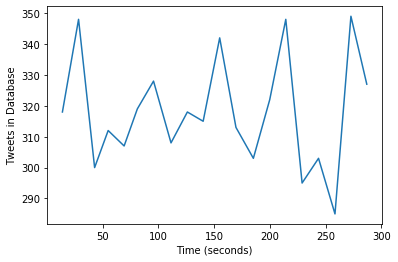

In [71]:
count_list = []
time_list = []
for tweet_count in tweet_count_list:
    count_list.append(tweet_count[0])
    time_list.append(tweet_count[1])
    
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(time_list, count_list)
plt.xlabel('Time (seconds)')
plt.ylabel ('Tweets in Database')
plt.show()

In [21]:
docDF = sqlContext.sql('Select * from tweets')
df = docDF.toPandas()
print(df.shape)
print(print("%d tweets in %d seconds" % (df.shape[0], toc-tic)))
df.head()

(278, 2)
278 tweets in 70 seconds
None


,words,count
0,"[mkzznrt, skynew, coronavirus, italian, heed, ...",1
1,[],1
2,"[hunter, coronavirus, camomilecloud, unfair, s...",1
3,[],1
4,"[tonight, game, postpon, arsenal, player, staf...",1


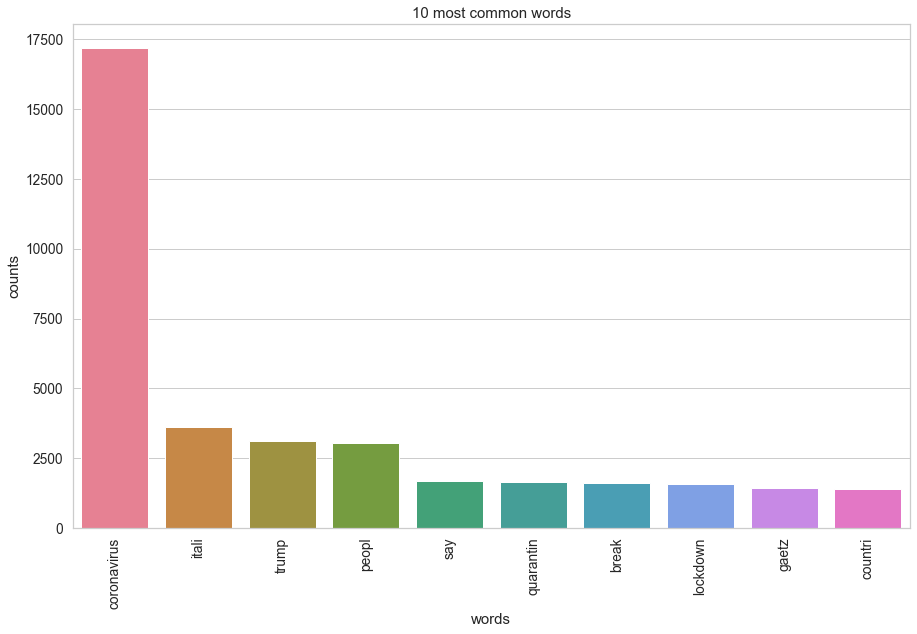

In [84]:
papers = df.drop(columns=['count'], axis=1)
papers['words'] = papers['words'].apply(lambda x: ', '.join(x))
papers = papers[papers.words != '']

from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
count_vectorizer = CountVectorizer(stop_words='english')
count_data = count_vectorizer.fit_transform(papers['words'])
plot_10_most_common_words(count_data, count_vectorizer)

In [85]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
number_topics = 5
number_words = 10
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
print_topics(lda, count_vectorizer, number_words)


Topic #0:
coronavirus trump outbreak say presid fear realdonaldtrump itali thing peopl

Topic #1:
coronavirus year case collin doug matt quarantin gaetz trump week

Topic #2:
coronavirus trump itali peopl quarantin gaetz self say break forc

Topic #3:
coronavirus itali peopl lockdown countri break say like news trump

Topic #4:
coronavirus itali sick peopl time quarantin lockdown gaetz break virus


In [86]:
from wordcloud import WordCloud

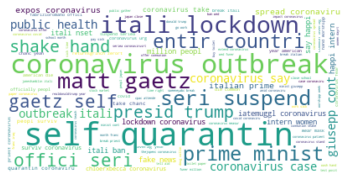

In [87]:
text = " ".join(tweet for tweet in papers.words)
wordcloud = WordCloud(background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()